### Load the data

In [171]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
from neel_plotly.plot import line
from helpers import loss_fn
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace
import tqdm.auto as tqdm
import os
from pathlib import Path
from helpers import rolling_average

CREATE_ESTIMATES = True
TUNE_HYPERPARAMS = True

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42

if CREATE_ESTIMATES:
    LOAD_LOCATION = "../saves/check_point_50/grokking_add_multi_0.5.pth"

    cached_data = torch.load(LOAD_LOCATION, weights_only=False)

    state_dict = cached_data['model']
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    #add_test_losses = cached_data['add_test_losses']
    #multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    #addition_frac = cached_data['addition_frac']
    train_data = cached_data['train_data']
    train_labels = cached_data['train_labels']

    # print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")
    print(f"train_data.shape = {train_data.shape} train_labels.shape = {train_labels.shape}")
    print(f"train_data[:5] = {train_data[:5]} train_labels[:5] = {train_labels[:5]}")

len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120
train_data.shape = torch.Size([16900, 3]) train_labels.shape = torch.Size([16900])
train_data[:5] = tensor([[ 96,   0,  74],
        [ 68,   0,  82],
        [121,   1,  24],
        [ 69,   0,   9],
        [ 42,   1,  35]]) train_labels[:5] = tensor([98, 39, 32, 56, 77])


In [172]:
from torch.utils.data import TensorDataset, DataLoader
if CREATE_ESTIMATES:
    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    print(f"train_loader = {len(train_loader)}")

train_loader = 529


### Setup the Model

In [173]:
if CREATE_ESTIMATES:
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 4,
        d_model = 128,
        d_head = 32,
        d_mlp = 512,
        act_fn = "relu",
        normalization_type= "LN" if "blocks.0.ln1.w" in state_dict else None,
        d_vocab=max_nums+1,
        d_vocab_out=mod_value,
        n_ctx= train_data.shape[1],
        init_weights=True,
        device=device,
        seed = RAND_SEED,
    )

    model = HookedTransformer(cfg)

### Local Learning Coefficient (RLCT) Estimation

#### Config

In [174]:
lr = 3e-2
num_chains = 3
num_draws = 150
num_burnin_steps = 50
num_steps_bw_draws = 1
gamma = 5
nbeta = 1.6
sampling_method = "sgld"

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

#### Find the right hyperparameters

In [175]:
import typing
from typing import Type

import numpy as np


def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 3,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = torch.device("cpu"),
    online: bool = True,
    verbose: bool = False,
):

    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [165]:
from devinterp.vis_utils import EpsilonBetaAnalyzer

if TUNE_HYPERPARAMS:
    model.load_state_dict(state_dict)
    analyzer = EpsilonBetaAnalyzer()
    analyzer.configure_sweep(
        llc_estimator=estimate_llc_given_model,
        llc_estimator_kwargs=dict(
            model=model,
            evaluate=evaluate,
            device=device,
            loader=train_loader,
        ),
        min_epsilon=3e-5,
        max_epsilon=3e-1,
        epsilon_samples=5,
        min_beta=None,
        max_beta=None,
        beta_samples=5,
        dataloader=train_loader,
    )
    analyzer.sweep()

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/vis_utils.py:86: UserWarning:

Epsilon values greater than 1e-2 typically lead to instability in the sampling process. Consider reducing epsilon to between 1e-6 and 1e-2.

  0%|          | 0/25 [00:00<?, ?it/s]/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:236: UserWarning:

You are taking more sample batches than there are dataloader batches available, this removes some r

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  4%|▍         | 1/25 [00:05<02:07,  5.30s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  8%|▊         | 2/25 [00:10<02:01,  5.29s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 12%|█▏        | 3/25 [00:15<01:57,  5.33s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 16%|█▌        | 4/25 [00:21<01:51,  5.31s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 20%|██        | 5/25 [00:26<01:46,  5.34s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 24%|██▍       | 6/25 [00:32<01:41,  5.36s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 28%|██▊       | 7/25 [00:37<01:37,  5.43s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 32%|███▏      | 8/25 [00:43<01:32,  5.45s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 36%|███▌      | 9/25 [00:48<01:27,  5.45s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 40%|████      | 10/25 [00:54<01:21,  5.46s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 44%|████▍     | 11/25 [00:59<01:16,  5.47s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 48%|████▊     | 12/25 [01:04<01:10,  5.45s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 52%|█████▏    | 13/25 [01:10<01:05,  5.44s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 56%|█████▌    | 14/25 [01:16<01:00,  5.53s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 56%|█████▌    | 14/25 [01:17<01:00,  5.52s/it]


KeyboardInterrupt: 

In [81]:
if TUNE_HYPERPARAMS:
    analyzer.plot()

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:277: UserWarning:

If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.



nbeta = 1.6 gamma = 5 lr = 0.03
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 139.24it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 168.25it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 166.50it/s]


results.keys() = dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])
results['llc/means'] = [19.114992 20.04467  15.979257 18.525404 18.004158 17.027468 16.495403
 18.332117 19.597038 18.786081 19.572725 19.605951 17.612486 19.918327
 19.748981 16.98278  19.435335 19.601519 25.198442 20.868402 19.379366
 19.435753 22.151598 15.505749 18.683908 22.112112 19.626123 22.239016
 22.287216 21.183107 21.293192 18.064531 19.309866 18.340982 22.007406
 17.622932 19.061167 18.794401 17.964348 21.152838 18.462519 18.397768
 18.591423 16.866228 19.102472 18.907553 20.332037 19.827036 19.119287
 19.647558 18.56539  17.195929 18.94151  18.130651 19.105417 19.38735
 18.753029 18.457655 19.86468  18.506342 16.640333 19.881617 17.513445
 17.29753  19.642836 20.148703 19.304573 18.227667 20.357737 17.821772
 19.285902 20.233416 17.270166 19.439272 19.89981  20.934235 19.813375
 20.107725 17.04687  19.590117 17.419147 18.701185 18.659044 20.007477
 20.074331 20.532984 18.464691 1

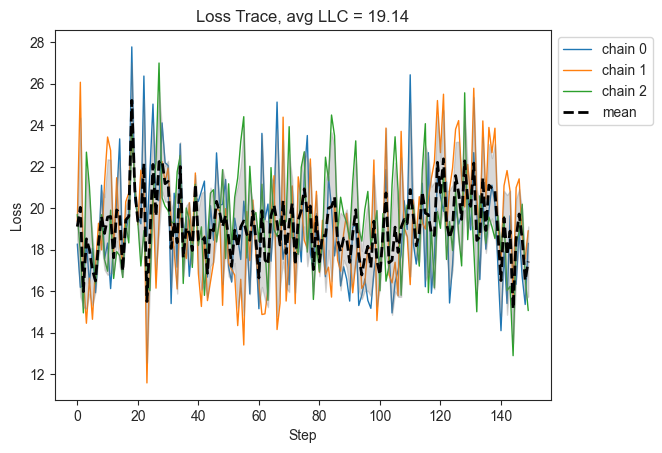

<Figure size 1200x900 with 0 Axes>

In [176]:
if TUNE_HYPERPARAMS:
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")

    model.load_state_dict(state_dict=state_dict)

    results = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=True,
                )
    print(f"results.keys() = {results.keys()}")
    print(f"results['llc/means'] = {results['llc/means']}")
    print(f"results['llc/stds'] = {results['llc/stds']}")
    print(f"results['llc/trace'].shape = {results['llc/trace'].shape}")
    print(f"results['llc/trace'] = {results['llc/trace']}")

    plot_trace(
        results["llc/trace"],
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

### Estimate for model checkpoints

In [96]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

if CREATE_ESTIMATES:
    # print(f"Addition frac = {addition_frac} Train frac = {train_frac}")
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")
    llc_estimates = []

    for saved_model in tqdm.tqdm(model_checkpoints):
        model.load_state_dict(saved_model)
        result = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=False,
                )
        print(f"result['llc/mean'] = {result["llc/mean"]}")
        llc_estimates.append(result["llc/mean"])

nbeta = 1.6 gamma = 5 lr = 0.03


  0%|          | 0/120 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 244.27it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 272.69it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 275.86it/s]


result['llc/mean'] = nan
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 290.36it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 275.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 279.68it/s]


result['llc/mean'] = nan
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 281.60it/s]


Moving model to device:  cpu


Chain 1:   0%|          | 1/200 [00:00<00:01, 135.32it/s]


KeyboardInterrupt: 

### Save the data

In [314]:
SAVE_LOCATION = "../saves/check_point_50/llc_estimates_0.3.pth"

if CREATE_ESTIMATES:
    os.makedirs(Path(SAVE_LOCATION).parent, exist_ok=True)
    torch.save({
        "llc_estimates": llc_estimates,
        "lr": lr,
        "nbeta": nbeta,
        "gamma": gamma,
        "num_chains": num_chains,
        "num_draws": num_draws,
        "num_burnin_steps": num_burnin_steps,
        "num_steps_bw_draws": num_steps_bw_draws,
        "sampling_method": sampling_method,
        "train_frac": train_frac,
        "addition_frac": addition_frac,
        "LOAD_LOCATION": LOAD_LOCATION,
    }, SAVE_LOCATION)
    print(f"addition_frac = {addition_frac} train_frac = {train_frac}")
    print(f"Saved to {SAVE_LOCATION}")

addition_frac = 0.3 train_frac = 0.5
Saved to ../saves/check_point_50/llc_estimates_0.3.pth


### Load data

In [10]:
LOAD_DATA_PATH = "../saves/check_point_50/llc_estimates_0.5.pth"
if not CREATE_ESTIMATES:
    cached_data = torch.load(LOAD_DATA_PATH, weights_only=False)
    llc_estimates = cached_data['llc_estimates']
    lr = cached_data['lr']
    nbeta = cached_data['nbeta']
    gamma = cached_data['gamma']
    num_chains = cached_data['num_chains']
    num_draws = cached_data['num_draws']
    num_burnin_steps = cached_data['num_burnin_steps']
    num_steps_bw_draws = cached_data['num_steps_bw_draws']
    sampling_method = cached_data['sampling_method']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    training_data_path = cached_data['LOAD_LOCATION']
    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")

    training_data = torch.load(training_data_path, weights_only=False)
    train_losses = training_data['train_losses']
    test_losses = training_data['test_losses']
    add_test_losses = training_data['add_test_losses']
    multi_test_losses = training_data['multi_test_losses']
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)}")

addition_frac = 0.5 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.5.pth
len(train_losses) = 6000 len(test_losses) = 6000


## Make some cool graphs

In [313]:
average_window = 5
llc_estimates_avg = rolling_average(llc_estimates, average_window)
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title=f"LLC - addition_frac = {addition_frac} nbeta = {nbeta} epsilon = {lr} gamma = {gamma}", log_y=False, toggle_x=True, toggle_y=True)
line(llc_estimates_avg, xaxis="Epoch", yaxis="Rolling Average LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)